In [ ]:
!pip install Sastrawi pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import re
import pickle
import nltk
import numpy as np
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from tqdm import tqdm
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
file_path = '/content/hasil_crawling.csv'
data = pd.read_csv(file_path)
data

,Title,Date,Content,Category
0,PalmCo Dukung Cyber Education di Sekolah Remot...,Ade Hapsari Lestarini • 11 September 2024 08:59,Jakarta: Sub Holding Perkebunan Nusantara PTPN...,Ekonomi
1,Harga Jual Emas Antam Melesat Rp13 Ribu/Gram,Arif Wicaksono • 11 September 2024 08:55,Jakarta: Harga emas batangan PT Aneka Tambang ...,Ekonomi
2,Terpopuler Ekonomi: Pascamerger Angkasa Pura h...,Ade Hapsari Lestarini • 11 September 2024 08:28,Jakarta: Berita-berita terpopuler ekonomi pada...,Ekonomi
3,Inflasi dan Debat Presiden AS Bikin Harga Emas...,Ade Hapsari Lestarini • 11 September 2024 08:12,Jakarta: Harga emas dunia menguat pada sesi pe...,Ekonomi
4,"Harga Minyak Mentah Brent Terpental ke USD69,1...",Ade Hapsari Lestarini • 11 September 2024 07:57,New York: Harga minyak mentah dunia terpantau ...,Ekonomi
...,...,...,...,...
95,Indonesia Ditunjuk jadi Tuan Rumah World Abili...,Gregorius Gelino • 6 September 2024 12:07,Paris: Menteri Pemuda dan Olahraga Republik In...,Olahraga
96,Menpora Berharap Banyak dengan PON XXI Aceh-Sumut,Gregorius Gelino • 6 September 2024 11:19,Jakarta: Menteri Pemuda dan Olahraga Republik ...,Olahraga
97,IFG Labuan Bajo Marathon 2024 Siapkan Hadiah R...,Gregorius Gelino • 6 September 2024 10:25,Labuan Bajo: Pendaftaran IFG Labuan Bajo Marat...,Olahraga
98,Hasil Pertandingan UEFA Nations League,Alfa Mandalika • 6 September 2024 09:22,Jakarta: Sejumlah negara melakoni laga UEFA Na...,Olahraga


In [ ]:
df_acak = data.sample(frac=1).reset_index(drop=True)
df_acak

,Title,Date,Content,Category
0,Jonatan Christie Senang Kembali Mentas,Gregorius Gelino • 8 September 2024 20:29,Jakarta: Pebulu tangkis tunggal putra Jonatan ...,Olahraga
1,Perusahaan Pembangkit Listrik Italia Hengkang ...,Arif Wicaksono • 10 September 2024 22:09,Hanoi: Perusahaan pembangkit listrik asal Ital...,Ekonomi
2,Tim Panjat Tebing Putri Jatim Sabet Emas Nomor...,Gregorius Gelino • 9 September 2024 13:21,"Banda Aceh: Tim panjat tebing Jawa Timur, Eka...",Olahraga
3,"Erick Thohir Rombak Direksi Bulog, Tunjuk Wahy...",Annisa Ayu Artanti • 10 September 2024 09:00,,Ekonomi
4,YCAB Foundation-Juara Capital Indonesia Luncur...,10 September 2024 16:40,Jakarta: YCAB Foundation bersama Juara Capital...,Ekonomi
...,...,...,...,...
95,"Pangkas Birokrasi Pascamerger AP I dan AP 2, J...",Insi Nantika Jelita • 10 September 2024 08:57,,Ekonomi
96,Perdagangan Emas di Bursa Komoditi Bakal Jadi ...,Ade Hapsari Lestarini • 10 September 2024 10:36,Jakarta: Perdagangan emas di bursa komoditi di...,Ekonomi
97,Kirab Api PON XXI Aceh Tiba di Banda Aceh,Fajri Fatmawati • 7 September 2024 13:52,Banda Aceh: Kirab Api Pekan Olahraga Nasional ...,Olahraga
98,Deschamps Kesal Pemain Prancis Lengah Lawan It...,Gregorius Gelino • 8 September 2024 10:20,Paris: Prancis menelan kekalahan pada laga per...,Olahraga


In [ ]:
# Pastikan nama kolom sesuai dengan kolom yang berisi judul dan isi berita
titles = data['Title']  # Gantilah 'judul_berita' dengan nama kolom judul yang sesuai
contents = data['Content']  # Gantilah 'isi_berita' dengan nama kolom isi yang sesuai
# Gabungkan judul dan isi menjadi satu teks untuk setiap dokumen
data['Content'] = titles + " " + contents

In [ ]:
# 2. Split data sebelum preprocessing
X = data['Content']  # Menggunakan kolom 'Content' gabungan sebagai fitur
y = data['Category']  # Kolom target (label)

# Melakukan split data menjadi 80% training dan 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 2. Preprocessing
def clean_lower(text):
    if isinstance(text, str):
        return text.lower()
    return text

def clean_punct(text):
    if isinstance(text, str):
        clean_patterns = re.compile(r'[0-9]|[/(){}\[\]\|@,;_]|[^a-z ]')
        text = clean_patterns.sub(' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return text

def _normalize_whitespace(text):
    if isinstance(text, str):
        corrected = re.sub(r'\s+', ' ', text)
        return corrected.strip()
    return text

def clean_stopwords(text):
    if isinstance(text, str):
        stopword = set(stopwords.words('indonesian'))
        text = ' '.join(word for word in text.split() if word not in stopword)
        return text.strip()
    return text

def sastrawistemmer(text):
    factory = StemmerFactory()
    st = factory.create_stemmer()
    text = ' '.join(st.stem(word) for word in text.split())
    return text

In [ ]:
#Terapkan preprocessing pada data training dan testing secara terpisah
X_train = X_train.apply(clean_lower)
X_train = X_train.apply(clean_punct)
X_train = X_train.apply(_normalize_whitespace)
X_train = X_train.apply(clean_stopwords)
X_train = X_train.apply(sastrawistemmer)
X_test = X_test.apply(clean_lower)
X_test = X_test.apply(clean_punct)
X_test = X_test.apply(_normalize_whitespace)
X_test = X_test.apply(clean_stopwords)
X_test = X_test.apply(sastrawistemmer)

In [ ]:
train_df = pd.DataFrame({'stemmed': X_train, 'Category': y_train})
test_df = pd.DataFrame({'stemmed': X_test, 'Category': y_test})

train_df

,stemmed,Category
55,tim panjat tebing putri jatim sabet emas nomor...,Olahraga
88,intip penalti gagal maarten paes baru lawan ar...,Olahraga
26,ekonomi as soft landing chicago ekonomi amerik...,Ekonomi
42,semen hijau ancam ubah iklim dunia jakarta pt ...,Ekonomi
69,pon xxi aceh sumut muncul bakat panjat tebing ...,Olahraga
...,...,...
60,kolaborasi lancar bikin menpora pon xxi aceh s...,Olahraga
71,hummels kes sosok de rossi roma bek as roma ma...,Olahraga
14,tan copot direktur gegara main calo barang jasa,Ekonomi
92,abraham wenas labuh kesatria bengawan solo sol...,Olahraga


In [ ]:
test_df

,stemmed,Category
83,warga aceh antusias saksi tanding basket pon x...,Olahraga
53,shin tae yong hadir sesi latih timnas indonesi...,Olahraga
70,menko pmk pasti presiden hadir buk pon xxi ace...,Olahraga
45,harga emas antam hasil tipis jakarta harga ema...,Ekonomi
44,erick thohir rombak direksi bulog wahyu supary...,Ekonomi
39,dagang emas bursa komoditi pilih masyarakat ja...,Ekonomi
22,bahlil timbang lanjut operasi pltu,Ekonomi
80,timnas indonesia sponsor jakarta extrajoss min...,Olahraga
10,anggota holding pupuk indonesia dorong ekosist...,Ekonomi
0,palmco dukung cyber education sekolah remote a...,Ekonomi


In [ ]:
# Menggunakan TfidfVectorizer untuk menghitung TF-IDF
tfidf_vectorizer = TfidfVectorizer()

# Melakukan fit dan transform pada data training
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Melakukan transform pada data testing (hanya transform, tidak fit)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# X_train_tfidf dan X_test_tfidf sekarang berisi representasi TF-IDF dari data training dan testing

In [ ]:
# Menampilkan data TF-IDF dalam bentuk DataFrame
tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Menampilkan beberapa baris pertama dari DataFrame
tfidf_df

,abadi,abbeele,abdullah,abilitysport,abilitysprot,abraham,absen,acara,aceh,ada,...,york,yose,youth,yunani,yusrizal,za,zeki,zian,zona,zuri
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.176186,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.059791,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.388843,0.045726,...,0.0,0.0,0.0,0.0,0.000000,0.053634,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.05601,0.293105,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
76,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
77,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
78,0.0,0.0,0.0,0.0,0.0,0.528422,0.0,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0


In [ ]:
# Menampilkan data TF-IDF dalam bentuk DataFrame
tfidf_df = pd.DataFrame(X_test_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Menampilkan beberapa baris pertama dari DataFrame
tfidf_df

,abadi,abbeele,abdullah,abilitysport,abilitysprot,abraham,absen,acara,aceh,ada,...,york,yose,youth,yunani,yusrizal,za,zeki,zian,zona,zuri
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.376001,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142301,0.372335,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.029647,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.026648,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0


In [ ]:
# Encode label untuk Logistic Regression
label_encoder = preprocessing.LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
# List untuk menyimpan hasil akurasi pada setiap jumlah dimensi
accuracy_results = []

# Mulai dari jumlah dimensi awal, 2249
current_dim = X_train_tfidf.shape[1]

In [ ]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
# Looping untuk mengurangi jumlah dimensi sebanyak 20 pada setiap iterasi
while current_dim >= 100:
    print(f"Reducing dimensions to {current_dim}")

    # Inisialisasi dan fit SVD
    svd = TruncatedSVD(n_components=current_dim, random_state=42)

    # Lakukan reduksi dimensi pada data training dan testing
    X_train_lsa = svd.fit_transform(X_train_tfidf)
    X_test_lsa = svd.transform(X_test_tfidf)

    # Melatih model Logistic Regression pada data yang telah direduksi
    lr_model = LogisticRegression()
    lr_model.fit(X_train_lsa, y_train_encoded)

    # Prediksi pada data testing
    y_pred = lr_model.predict(X_test_lsa)

    # Menghitung akurasi dan menambahkannya ke dalam list
    accuracy = accuracy_score(y_test_encoded, y_pred)
    accuracy_results.append({"Dimensions": current_dim, "Accuracy": accuracy})

    # Menampilkan accuracy untuk setiap current_dim
    print(f"Accuracy with {current_dim} components: {accuracy}")

    # Kurangi jumlah dimensi sebanyak 20 untuk iterasi berikutnya
    current_dim -= 20

Reducing dimensions to 2249
Accuracy with 2249 components: 0.95
Reducing dimensions to 2229
Accuracy with 2229 components: 0.95
Reducing dimensions to 2209
Accuracy with 2209 components: 0.95
Reducing dimensions to 2189
Accuracy with 2189 components: 0.95
Reducing dimensions to 2169
Accuracy with 2169 components: 0.95
Reducing dimensions to 2149
Accuracy with 2149 components: 0.95
Reducing dimensions to 2129
Accuracy with 2129 components: 0.95
Reducing dimensions to 2109
Accuracy with 2109 components: 0.95
Reducing dimensions to 2089
Accuracy with 2089 components: 0.95
Reducing dimensions to 2069
Accuracy with 2069 components: 0.95
Reducing dimensions to 2049
Accuracy with 2049 components: 0.95
Reducing dimensions to 2029
Accuracy with 2029 components: 0.95
Reducing dimensions to 2009
Accuracy with 2009 components: 0.95
Reducing dimensions to 1989
Accuracy with 1989 components: 0.95
Reducing dimensions to 1969
Accuracy with 1969 components: 0.95
Reducing dimensions to 1949
Accuracy wit

In [ ]:
# Membuat DataFrame dari hasil akurasi
accuracy_df = pd.DataFrame(accuracy_results)

# Menampilkan tabel akurasi
accuracy_df

,Dimensions,Accuracy
0,2249,0.95
1,2229,0.95
2,2209,0.95
3,2189,0.95
4,2169,0.95
...,...,...
103,189,0.95
104,169,0.95
105,149,0.95
106,129,0.95


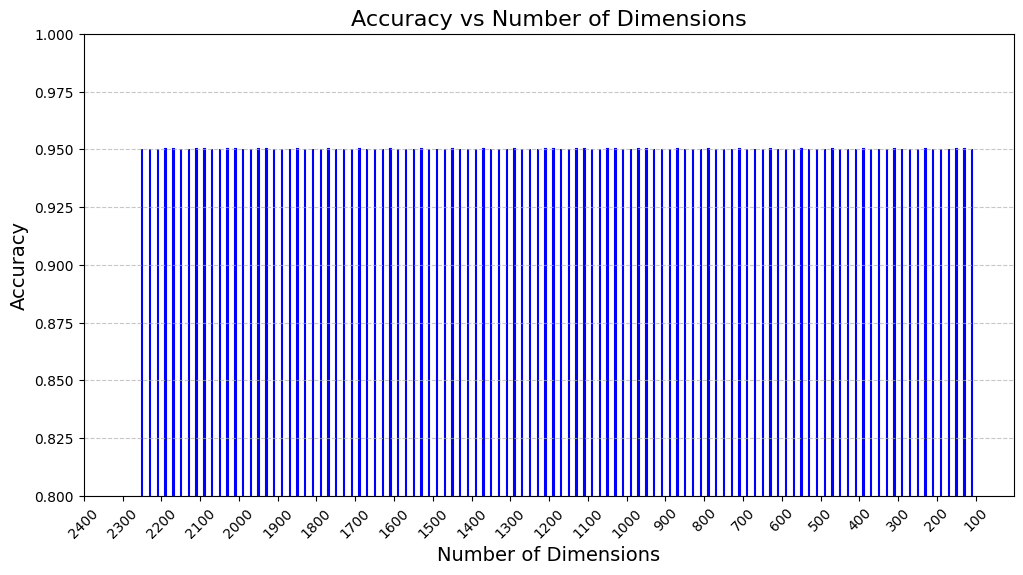

In [ ]:
import matplotlib.pyplot as plt

# Plot akurasi vs jumlah dimensi menggunakan grafik balok
plt.figure(figsize=(12, 6))
plt.bar(accuracy_df["Dimensions"], accuracy_df["Accuracy"], color='skyblue', edgecolor='blue', linewidth=1.5)
plt.title("Accuracy vs Number of Dimensions", fontsize=16)
plt.xlabel("Number of Dimensions", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)

# Atur batas y agar mulai dari 0.8
plt.ylim(0.8, 1.0)

# Tambahkan grid untuk sumbu y
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Membalik sumbu x agar dimensi berkurang dari kiri ke kanan
plt.gca().invert_xaxis()

# Menampilkan tick marks pada sumbu x dengan interval 100, 200, 300, ...
plt.xticks(range(100, 2500, 100), rotation=45)

plt.show()
